## Project Documentation

This notebook demonstrates the steps involved in performing classification on a headgear dataset.

In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd 
import os
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import image_dataset_from_directory
from matplotlib import pyplot as plt


# Data Loading 🔋 🔌

In [2]:
# Create some folders that will store the training and test data.
IMG_SIZE = (224, 224)

TRAINING_DIR ="/kaggle/input/headgear-image-classification/train/"
Valid_DIR="/kaggle/input/headgear-image-classification/valid/"
TESTING_DIR ="/kaggle/input/headgear-image-classification/test/"

train_data = image_dataset_from_directory(TRAINING_DIR,
                                          batch_size=64,
                                          image_size=IMG_SIZE
                                         )

val_data = image_dataset_from_directory(Valid_DIR,
                                        batch_size=64,
                                        image_size=IMG_SIZE
                                       )

test_data = image_dataset_from_directory(TESTING_DIR,
                                         batch_size=64,
                                         image_size=IMG_SIZE
                                        )

Found 3620 files belonging to 20 classes.
Found 100 files belonging to 20 classes.
Found 100 files belonging to 20 classes.


In [3]:
# Counting the number of files in each class of the training dataset and store the counts in a dictionary.
data_path = "/kaggle/input/headgear-image-classification/train/"

label_counts = {}
for label in train_data.class_names:
    file_names = os.listdir(f"{data_path}/{label}")
    label_counts[label] = len(file_names)

num_classes = len(label_counts)

# Building The Model

Let's try a `EfficientNetB0` to see how well it would perform on our data

## Data Preprocessing

Preprocessing the data by casting the images to float32, applying `ResNet50` preprocessing, and parallelizing the mapping process. Then, cache, shuffle, and prefetch the training and validation for improved performance.

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_data = train_data.map(preprocess_data, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(preprocess_data, num_parallel_calls=AUTOTUNE)

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Define the Network
Performing transfer learning on **EfficientNetB0** available in Keras.
- load pre-trained **imagenet weights** to the model.
- choose to retain all layers of **EfficientNetB0** along with the final classification layers.

In [5]:
def feature_extractor(inputs):
    basemodel = EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    feature_extractor = basemodel(inputs)
    return feature_extractor


In [6]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(num_classes, activation="softmax", name="classification")(x)
    return x

In [7]:
def final_model(inputs):

    efficientnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(efficientnet_feature_extractor)

    return classification_output

In [8]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer= tf.keras.optimizers.Adam(), 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [9]:
model = define_compile_model()

model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800 

# Training the Model

In [10]:
history = model.fit(train_data,
                    epochs=25,
                    validation_data = val_data,
                    batch_size=64)

Epoch 1/25


2023-06-08 11:52:05.702686: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


57/57 [==============================] - 108s 553ms/step - loss: 0.8724 - accuracy: 0.7519 - val_loss: 0.6760 - val_accuracy: 0.8200
Epoch 2/25
57/57 [==============================] - 28s 487ms/step - loss: 0.2241 - accuracy: 0.9329 - val_loss: 0.3330 - val_accuracy: 0.8800
Epoch 3/25
57/57 [==============================] - 28s 492ms/step - loss: 0.1470 - accuracy: 0.9536 - val_loss: 0.4792 - val_accuracy: 0.9200
Epoch 4/25
57/57 [==============================] - 28s 498ms/step - loss: 0.1138 - accuracy: 0.9649 - val_loss: 0.5600 - val_accuracy: 0.9100
Epoch 5/25
57/57 [==============================] - 29s 504ms/step - loss: 0.0973 - accuracy: 0.9732 - val_loss: 0.3031 - val_accuracy: 0.9100
Epoch 6/25
57/57 [==============================] - 29s 505ms/step - loss: 0.1250 - accuracy: 0.9605 - val_loss: 0.4513 - val_accuracy: 0.9100
Epoch 7/25
57/57 [==============================] - 29s 504ms/step - loss: 0.1152 - accuracy: 0.9649 - val_loss: 0.6389 - val_accuracy: 0.8600
Epoch 8/2

# Plot Loss and Accuracy Curves

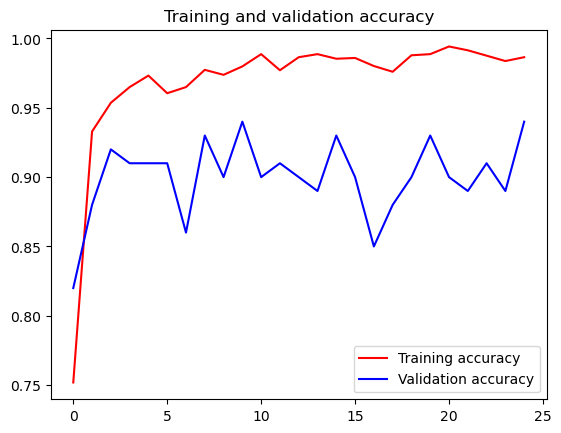

<Figure size 640x480 with 0 Axes>

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Evaluating the Model

In [17]:
loss, accuracy = model.evaluate(val_data, batch_size=64)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

2/2 [==============================] - 0s 87ms/step - loss: 0.2616 - accuracy: 0.9400
Test Loss: 0.2616392970085144, Test Accuracy: 0.9399999976158142


# Testing the Model

In [21]:
# Get the predicted probabilities for the images
probabilities = model.predict(test_data)
probabilities = np.argmax(probabilities, axis = 1)

2/2 [==============================] - 0s 137ms/step


Found 100 files belonging to 20 classes.


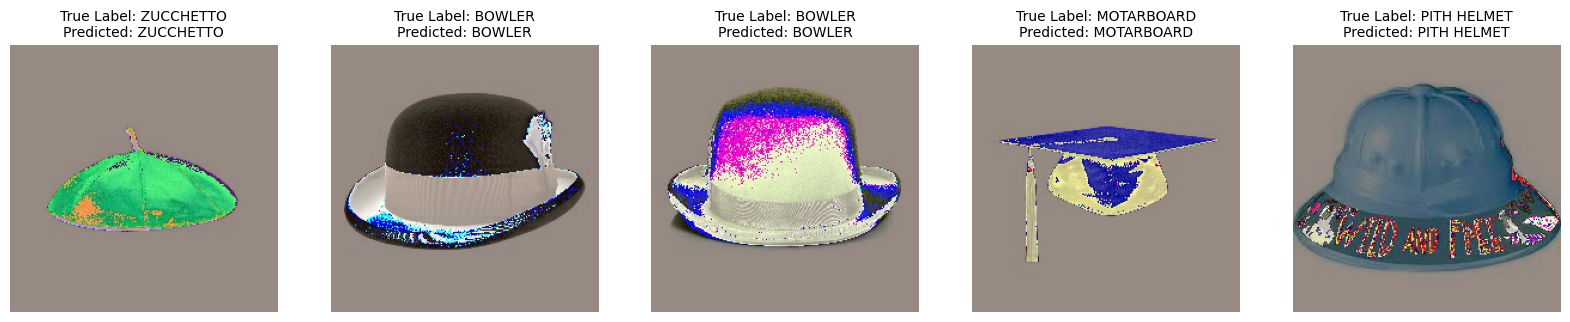

In [22]:
test1_data = image_dataset_from_directory(TESTING_DIR,
                                         batch_size=64,
                                         image_size=IMG_SIZE
                                        )

plt.figure(figsize=(20, 10))
for images, labels in test_data.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Get the class name for the true label and predicted label
        true_label = 'True Label: '+test1_data.class_names[labels[i]]
        predicted_label = 'Predicted: '+test1_data.class_names[probabilities[i]]
        # Set the titles for the subplot
        plt.title(f"{true_label}\n{predicted_label}", fontsize=10)
        plt.axis("off")